Coded by Latherial Calbert | M.S. Statistics Student at the College of Charleston

Data Provided by Kyle Rees | Senior Market Research Manager @ Amazon

Parameter tuned by Aidan Riordan | B.S. Statistics Student at the College of Charleston, President Data Science Club


# Wine Price Prediction Model Analysis

## Overview
This notebook performs predictive modeling on wine price data using XGBoost regression with hyperparameter optimization. The analysis processed 2,595 wine entries with 1,933 features after one-hot encoding categorical variables.

## Model Development
1. **Data Preprocessing**:
  - Removed outliers using IQR method (retained 2,544 samples)
  - Standardized numerical features
  - One-hot encoded categorical variables

2. **Model Optimization**:
  - Performed RandomizedSearchCV with 30 parameter combinations
  - Used 3-fold cross-validation for parameter tuning
  - Selected best hyperparameters from 90 total model fits

## Results
The final model achieved:
- R² score: 0.691 (±0.017)
- Mean Absolute Error: $38.14 (±2.45)
- Mean Squared Error: 4,678.58 (±626.82)

## Key Price Drivers
Top 5 most influential features:
1. Country (France)
2. Producer (Chateau Mouton Rothschild)
3. Producer (Chateau Haut Brion)
4. Variety (Pinot Noir/Pinot Nero)
5. Region (Bordeaux)

## Conclusion
The model explains approximately 69% of the variance in wine prices, with an average prediction error of $38. This is good considering the standard deviation in price is 123.47 dollars, meaning our model's average error is less than one-third of the natural price variation in the dataset. French wines, particularly from prestigious producers in Bordeaux and Burgundy, are the strongest price indicators. The model performs reasonably well for price predictions, though there remains some unexplained variance likely due to factors not captured in the dataset (e.g., vintage quality ratings, market conditions).

Import Data

In [1]:
# Step 1: Import necessary libraries
import pandas as pd
#from google.colab import files

# Step 2: Upload the file
#uploaded = files.upload()

# Step 3: Load the Excel file into a DataFrame
# Replace 'amazon_wine.xlsx' with the correct filename if necessary
df = pd.read_excel("C:/Users/aidan/Desktop/Wine Amazon/amazon_wine.xlsx")

# Step 4: Display the first few rows of the DataFrame
df.head()


C:\Users\aidan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Producer,Product,Link,Price,Stock Availability,Bottle Size,Ratings,Reviewers,Description,Vintage,Variety,Region,Color/Type,Country,Appellation,SubRegion
0,Salon,2013 Salon - Champagne Brut Blanc de Blancs Le...,https://bassins.com/2013-salon-brut-blanc-de-b...,2900.0,1,1.5L,99,VM,"The 2013 is the most powerful, dense young Sal...",2013,Champagne,Champagne,Sparkling,France,Champagne,NaN
1,Georges Roumier,1999 Georges Roumier Bonnes Mares,https://bassins.com/1999-georges-roumier-bonne...,2700.0,3,750ml,97,VM,"Good deep red. Aromas of black raspberry, grap...",1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares,NaN
2,Henri Boillot,2020 Henri Boillot Montrachet,https://bassins.com/2020-henri-boillot-montrac...,2499.0,1,750ml,96-99,JM,1 x 350 litre barrel. Not especially deep in c...,2020,Chardonnay,Burgundy,White,France,Montrachet,NaN
3,Giacosa,2016 Giacosa - Barbaresco Riserva Asili DOUBLE...,https://bassins.com/2016-giacosa-barbaresco-ri...,2400.0,1,3L,97+,WA,"Packaged in its distinctive red label, the 201...",2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG,NaN
4,Krug,2008 Krug - Brut Clos du Mesnil,https://bassins.com/2008-krug-brut-clos-du-mesnil,2100.0,2,750ml,99,VM,"Krug’s 2008 Clos du Mesnil, tasted from two bo...",2008,Champagne,Champagne,Sparkling,France,Brut,NaN


Check shape and null values

In [2]:
df.shape

(3314, 16)

In [3]:
# Step 5: Count NaN values in each column and print them
nan_counts = df.isna().sum()
print("Number of NaN values in each column:")
print(nan_counts)


Number of NaN values in each column:
Producer                 0
Product                  0
Link                     0
Price                    0
Stock Availability       0
Bottle Size              0
Ratings               1330
Reviewers             1330
Description           1394
Vintage                 36
Variety                360
Region                   4
Color/Type               0
Country                  0
Appellation            147
SubRegion             3193
dtype: int64


Drop columns that are not helpful for predictions or have too many null values

In [4]:
# Step 6: Drop specified columns and create a copy of the DataFrame
columns_to_drop = ['Ratings', 'Reviewers', 'Description', 'SubRegion']
amazon_wine_price = df.drop(columns=columns_to_drop).copy()

# Display the first few rows of the new DataFrame
print("First few rows of the new DataFrame (amazon_wine_price):")
amazon_wine_price.head()


First few rows of the new DataFrame (amazon_wine_price):


,Producer,Product,Link,Price,Stock Availability,Bottle Size,Vintage,Variety,Region,Color/Type,Country,Appellation
0,Salon,2013 Salon - Champagne Brut Blanc de Blancs Le...,https://bassins.com/2013-salon-brut-blanc-de-b...,2900.0,1,1.5L,2013,Champagne,Champagne,Sparkling,France,Champagne
1,Georges Roumier,1999 Georges Roumier Bonnes Mares,https://bassins.com/1999-georges-roumier-bonne...,2700.0,3,750ml,1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares
2,Henri Boillot,2020 Henri Boillot Montrachet,https://bassins.com/2020-henri-boillot-montrac...,2499.0,1,750ml,2020,Chardonnay,Burgundy,White,France,Montrachet
3,Giacosa,2016 Giacosa - Barbaresco Riserva Asili DOUBLE...,https://bassins.com/2016-giacosa-barbaresco-ri...,2400.0,1,3L,2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG
4,Krug,2008 Krug - Brut Clos du Mesnil,https://bassins.com/2008-krug-brut-clos-du-mesnil,2100.0,2,750ml,2008,Champagne,Champagne,Sparkling,France,Brut


See new amount of null values

In [5]:
# Step 5: Count NaN values in each column and print them
nan_counts = amazon_wine_price.isna().sum()
print("Number of NaN values in each column:")
print(nan_counts)


Number of NaN values in each column:
Producer                0
Product                 0
Link                    0
Price                   0
Stock Availability      0
Bottle Size             0
Vintage                36
Variety               360
Region                  4
Color/Type              0
Country                 0
Appellation           147
dtype: int64


In [6]:
amazon_wine_price.shape

(3314, 12)

Drop the remaining null value observations

In [7]:
# Step 7: Drop all rows with NaN values from the amazon_wine_price DataFrame
amazon_wine_price = amazon_wine_price.dropna()

# Display the first few rows after dropping NaN values
print("First few rows of amazon_wine_price after dropping NaN rows:")
amazon_wine_price.head()


First few rows of amazon_wine_price after dropping NaN rows:


,Producer,Product,Link,Price,Stock Availability,Bottle Size,Vintage,Variety,Region,Color/Type,Country,Appellation
0,Salon,2013 Salon - Champagne Brut Blanc de Blancs Le...,https://bassins.com/2013-salon-brut-blanc-de-b...,2900.0,1,1.5L,2013,Champagne,Champagne,Sparkling,France,Champagne
1,Georges Roumier,1999 Georges Roumier Bonnes Mares,https://bassins.com/1999-georges-roumier-bonne...,2700.0,3,750ml,1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares
2,Henri Boillot,2020 Henri Boillot Montrachet,https://bassins.com/2020-henri-boillot-montrac...,2499.0,1,750ml,2020,Chardonnay,Burgundy,White,France,Montrachet
3,Giacosa,2016 Giacosa - Barbaresco Riserva Asili DOUBLE...,https://bassins.com/2016-giacosa-barbaresco-ri...,2400.0,1,3L,2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG
4,Krug,2008 Krug - Brut Clos du Mesnil,https://bassins.com/2008-krug-brut-clos-du-mesnil,2100.0,2,750ml,2008,Champagne,Champagne,Sparkling,France,Brut


In [8]:
amazon_wine_price.shape

(2773, 12)

In [9]:
# Step 8: Save the DataFrame to an Excel file and download it
amazon_wine_price.to_excel('amazon_wine_price.xlsx', index=False)

# Step 9: Use files.download to download the file
#from google.colab import files
#files.download('amazon_wine_price.xlsx')


Remove non numerical rows

In [10]:
# Step 10: Remove rows where the 'Vintage' column contains 'NV'
amazon_wine_price = amazon_wine_price[amazon_wine_price['Vintage'] != 'NV']

# Display the first few rows after removal
print("First few rows of amazon_wine_price after removing 'NV' in the 'Vintage' column:")
amazon_wine_price.head()


First few rows of amazon_wine_price after removing 'NV' in the 'Vintage' column:


,Producer,Product,Link,Price,Stock Availability,Bottle Size,Vintage,Variety,Region,Color/Type,Country,Appellation
0,Salon,2013 Salon - Champagne Brut Blanc de Blancs Le...,https://bassins.com/2013-salon-brut-blanc-de-b...,2900.0,1,1.5L,2013,Champagne,Champagne,Sparkling,France,Champagne
1,Georges Roumier,1999 Georges Roumier Bonnes Mares,https://bassins.com/1999-georges-roumier-bonne...,2700.0,3,750ml,1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares
2,Henri Boillot,2020 Henri Boillot Montrachet,https://bassins.com/2020-henri-boillot-montrac...,2499.0,1,750ml,2020,Chardonnay,Burgundy,White,France,Montrachet
3,Giacosa,2016 Giacosa - Barbaresco Riserva Asili DOUBLE...,https://bassins.com/2016-giacosa-barbaresco-ri...,2400.0,1,3L,2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG
4,Krug,2008 Krug - Brut Clos du Mesnil,https://bassins.com/2008-krug-brut-clos-du-mesnil,2100.0,2,750ml,2008,Champagne,Champagne,Sparkling,France,Brut


In [11]:
amazon_wine_price.shape

(2595, 12)

In [12]:
# Step 12: Create a copy of amazon_wine_price and clean the 'Bottle Size' column
amazon_wine_price_2 = amazon_wine_price.copy()
amazon_wine_price_2['Bottle Size'] = amazon_wine_price_2['Bottle Size'].astype(str).str.extract(r'([\d.]+)').astype(float)

# Display the first few rows after cleaning
print("First few rows of amazon_wine_price_2 after cleaning the 'Bottle Size' column:")
amazon_wine_price_2.head()


First few rows of amazon_wine_price_2 after cleaning the 'Bottle Size' column:


,Producer,Product,Link,Price,Stock Availability,Bottle Size,Vintage,Variety,Region,Color/Type,Country,Appellation
0,Salon,2013 Salon - Champagne Brut Blanc de Blancs Le...,https://bassins.com/2013-salon-brut-blanc-de-b...,2900.0,1,1.5,2013,Champagne,Champagne,Sparkling,France,Champagne
1,Georges Roumier,1999 Georges Roumier Bonnes Mares,https://bassins.com/1999-georges-roumier-bonne...,2700.0,3,750.0,1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares
2,Henri Boillot,2020 Henri Boillot Montrachet,https://bassins.com/2020-henri-boillot-montrac...,2499.0,1,750.0,2020,Chardonnay,Burgundy,White,France,Montrachet
3,Giacosa,2016 Giacosa - Barbaresco Riserva Asili DOUBLE...,https://bassins.com/2016-giacosa-barbaresco-ri...,2400.0,1,3.0,2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG
4,Krug,2008 Krug - Brut Clos du Mesnil,https://bassins.com/2008-krug-brut-clos-du-mesnil,2100.0,2,750.0,2008,Champagne,Champagne,Sparkling,France,Brut


In [13]:
import pandas as pd

# Assuming amazon_wine_price is your original DataFrame
amazon_wine_price_2 = amazon_wine_price.copy()

# Step 1: Store the original value to check for 'L' and 'ml', then remove the units and convert to numeric
def remove_units(value):
    if isinstance(value, str):
        # Save the original value to check later if it had 'L'
        original_value = value.strip()
        # Remove 'L' and 'ml' from the string
        value = value.replace('L', '').replace('ml', '').strip()
        return value, original_value
    return value, None

# Apply the function to remove 'L'/'ml' and store original value
amazon_wine_price_2['Processed Bottle Size'], amazon_wine_price_2['Original Bottle Size'] = zip(*amazon_wine_price_2['Bottle Size'].apply(remove_units))

# Step 2: Convert the cleaned-up values to numeric
amazon_wine_price_2['Processed Bottle Size'] = pd.to_numeric(amazon_wine_price_2['Processed Bottle Size'], errors='coerce')

# Step 3: Convert rows with 'L' (liters) to milliliters by checking the original value
def convert_liters_to_ml(row):
    # If the original value had 'L' (case-sensitive), multiply the processed value by 1000
    if 'L' in row['Original Bottle Size']:
        return row['Processed Bottle Size'] * 1000
    return row['Processed Bottle Size']

# Apply the conversion function
amazon_wine_price_2['Bottle Size'] = amazon_wine_price_2.apply(convert_liters_to_ml, axis=1)

# Drop the auxiliary columns used for processing
amazon_wine_price_2.drop(columns=['Processed Bottle Size', 'Original Bottle Size'], inplace=True)

# Display the first few rows after the conversion
print("First few rows of amazon_wine_price_2 after conversion:")
amazon_wine_price_2.head()


First few rows of amazon_wine_price_2 after conversion:


,Producer,Product,Link,Price,Stock Availability,Bottle Size,Vintage,Variety,Region,Color/Type,Country,Appellation
0,Salon,2013 Salon - Champagne Brut Blanc de Blancs Le...,https://bassins.com/2013-salon-brut-blanc-de-b...,2900.0,1,1500.0,2013,Champagne,Champagne,Sparkling,France,Champagne
1,Georges Roumier,1999 Georges Roumier Bonnes Mares,https://bassins.com/1999-georges-roumier-bonne...,2700.0,3,750.0,1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares
2,Henri Boillot,2020 Henri Boillot Montrachet,https://bassins.com/2020-henri-boillot-montrac...,2499.0,1,750.0,2020,Chardonnay,Burgundy,White,France,Montrachet
3,Giacosa,2016 Giacosa - Barbaresco Riserva Asili DOUBLE...,https://bassins.com/2016-giacosa-barbaresco-ri...,2400.0,1,3000.0,2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG
4,Krug,2008 Krug - Brut Clos du Mesnil,https://bassins.com/2008-krug-brut-clos-du-mesnil,2100.0,2,750.0,2008,Champagne,Champagne,Sparkling,France,Brut


Correlaton matrix

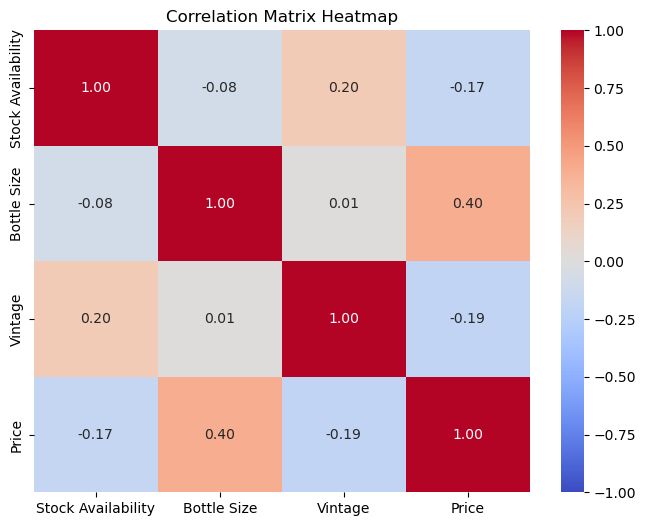

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy of the dataframe
amazon_corr = amazon_wine_price_2.copy()

# Step 1: Convert 'Stock Availability', 'Bottle Size', 'Vintage', and 'Price' to numeric
columns_to_convert = ['Stock Availability', 'Bottle Size', 'Vintage', 'Price']

# Convert the specified columns to numeric, coercing errors to NaN
for col in columns_to_convert:
    amazon_corr[col] = pd.to_numeric(amazon_corr[col], errors='coerce')

# Step 2: Drop rows with NaN values in these columns
amazon_corr = amazon_corr.dropna(subset=columns_to_convert)

# Step 3: Generate the correlation matrix for only the specified columns
correlation_matrix = amazon_corr[columns_to_convert].corr()

# Step 4: Create the heatmap for the correlation matrix
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

# Add a title for the heatmap
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()


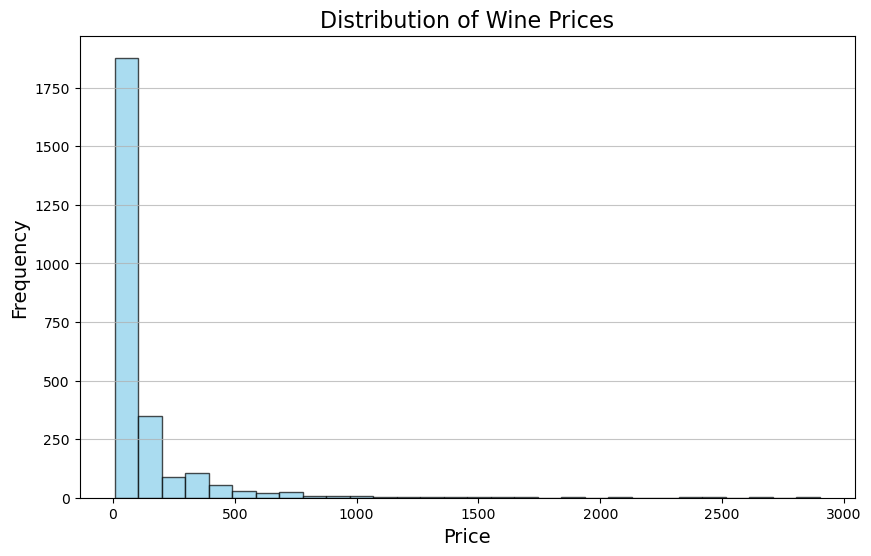

In [15]:
import matplotlib.pyplot as plt

# Plot the distribution of prices
plt.figure(figsize=(10, 6))
plt.hist(amazon_wine_price_2['Price'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Wine Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [16]:
amazon_wine_price_2.head()

,Producer,Product,Link,Price,Stock Availability,Bottle Size,Vintage,Variety,Region,Color/Type,Country,Appellation
0,Salon,2013 Salon - Champagne Brut Blanc de Blancs Le...,https://bassins.com/2013-salon-brut-blanc-de-b...,2900.0,1,1500.0,2013,Champagne,Champagne,Sparkling,France,Champagne
1,Georges Roumier,1999 Georges Roumier Bonnes Mares,https://bassins.com/1999-georges-roumier-bonne...,2700.0,3,750.0,1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares
2,Henri Boillot,2020 Henri Boillot Montrachet,https://bassins.com/2020-henri-boillot-montrac...,2499.0,1,750.0,2020,Chardonnay,Burgundy,White,France,Montrachet
3,Giacosa,2016 Giacosa - Barbaresco Riserva Asili DOUBLE...,https://bassins.com/2016-giacosa-barbaresco-ri...,2400.0,1,3000.0,2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG
4,Krug,2008 Krug - Brut Clos du Mesnil,https://bassins.com/2008-krug-brut-clos-du-mesnil,2100.0,2,750.0,2008,Champagne,Champagne,Sparkling,France,Brut


In [17]:
# Assuming amazon_wine_price_2 is the original dataframe

# Calculate the proportion of unique values for each feature
unique_proportions = {col: len(amazon_wine_price_2[col].unique()) / len(amazon_wine_price_2) for col in amazon_wine_price_2.columns}

# Print the proportion for each feature
for column, proportion in unique_proportions.items():
    print(f"Feature: {column}")
    print(f"Proportion of unique values: {proportion:.4f}")
    print("-" * 40)


Feature: Producer
Proportion of unique values: 0.4609
----------------------------------------
Feature: Product
Proportion of unique values: 0.9981
----------------------------------------
Feature: Link
Proportion of unique values: 1.0000
----------------------------------------
Feature: Price
Proportion of unique values: 0.1229
----------------------------------------
Feature: Stock Availability
Proportion of unique values: 0.0435
----------------------------------------
Feature: Bottle Size
Proportion of unique values: 0.0023
----------------------------------------
Feature: Vintage
Proportion of unique values: 0.0162
----------------------------------------
Feature: Variety
Proportion of unique values: 0.0193
----------------------------------------
Feature: Region
Proportion of unique values: 0.0470
----------------------------------------
Feature: Color/Type
Proportion of unique values: 0.0023
----------------------------------------
Feature: Country
Proportion of unique values: 0

Drop Link and Product features, too many unique values.

In [18]:
# Drop 'Link' and 'Product' columns from amazon_wine_price_2
amazon_wine_price_2 = amazon_wine_price_2.drop(columns=['Link', 'Product'])

# Display the first few rows of the cleaned DataFrame
amazon_wine_price_2.head()


,Producer,Price,Stock Availability,Bottle Size,Vintage,Variety,Region,Color/Type,Country,Appellation
0,Salon,2900.0,1,1500.0,2013,Champagne,Champagne,Sparkling,France,Champagne
1,Georges Roumier,2700.0,3,750.0,1999,Pinot Noir/Pinot Nero,Burgundy,Red,France,Bonnes Mares
2,Henri Boillot,2499.0,1,750.0,2020,Chardonnay,Burgundy,White,France,Montrachet
3,Giacosa,2400.0,1,3000.0,2016,Nebbiolo,Piemonte,Red,Italy,Barbaresco DOCG
4,Krug,2100.0,2,750.0,2008,Champagne,Champagne,Sparkling,France,Brut


Categorical encoding, remove extreme outliers

## Parameter tuning for slight improvement done by Aidan Riordan

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint

# One-hot encode categorical features
categorical_columns = amazon_wine_price_2.select_dtypes(include=['object']).columns
amazon_wine_price_2_encoded = pd.get_dummies(amazon_wine_price_2, columns=categorical_columns, drop_first=True)
print("Initial shape:", amazon_wine_price_2_encoded.shape)

# Remove extreme outliers based on IQR
Q1 = amazon_wine_price_2_encoded['Price'].quantile(0.1)
Q3 = amazon_wine_price_2_encoded['Price'].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
amazon_wine_price_2_encoded = amazon_wine_price_2_encoded[
    (amazon_wine_price_2_encoded['Price'] >= lower_bound) &
    (amazon_wine_price_2_encoded['Price'] <= upper_bound)
]
print("Shape after outlier removal:", amazon_wine_price_2_encoded.shape)

# Prepare features (X) and target (y)
X = amazon_wine_price_2_encoded.drop(columns=['Price'])
y = amazon_wine_price_2_encoded['Price']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define parameter distributions for random search
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.3),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

# Initialize base XGBoost model
base_model = xgb.XGBRegressor(random_state=42)

# Perform RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=30,  # Number of parameter settings sampled
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_scaled, y)

# Print best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print(f"Best cross-validation R² score: {random_search.best_score_:.3f}")

# Use best parameters for final model evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
mae_scores = []
mse_scores = []
feature_importances = []

# Perform cross-validation with best parameters
for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled), 1):
    # Split data
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model with best parameters
    xg_reg = xgb.XGBRegressor(**random_search.best_params_, random_state=42)
    xg_reg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xg_reg.predict(X_val)
    
    # Calculate metrics
    r2_scores.append(r2_score(y_val, y_pred))
    mae_scores.append(mean_absolute_error(y_val, y_pred))
    mse_scores.append(mean_squared_error(y_val, y_pred))
    
    # Store feature importance
    fold_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': xg_reg.feature_importances_,
        'fold': fold
    })
    feature_importances.append(fold_importance)

# Print final cross-validation results
print("\nFinal Cross-validation Results with Best Parameters:")
print(f"Mean R² score: {np.mean(r2_scores):.3f} (±{np.std(r2_scores):.3f})")
print(f"Mean MAE: {np.mean(mae_scores):.3f} (±{np.std(mae_scores):.3f})")
print(f"Mean MSE: {np.mean(mse_scores):.3f} (±{np.std(mse_scores):.3f})")

# Feature importance analysis
feature_importance_df = pd.concat(feature_importances)
feature_importance_summary = feature_importance_df.groupby('feature').agg({
    'importance': ['mean', 'std']
}).reset_index()
feature_importance_summary.columns = ['feature', 'importance_mean', 'importance_std']
feature_importance_summary = feature_importance_summary.sort_values('importance_mean', ascending=False)

print("\nTop 10 Most Important Features (across all folds):")
print("Format: Feature: Mean Importance ± Standard Deviation")
for _, row in feature_importance_summary.head(10).iterrows():
    print(f"{row['feature']}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

Initial shape: (2595, 1933)
Shape after outlier removal: (2544, 1933)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters found:
{'colsample_bytree': 0.706712405710114, 'gamma': 0.48830747791632645, 'learning_rate': 0.1333111039954694, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 484, 'subsample': 0.695824756266789}
Best cross-validation R² score: -25.469

Final Cross-validation Results with Best Parameters:
Mean R² score: 0.691 (±0.017)
Mean MAE: 38.135 (±2.446)
Mean MSE: 4678.578 (±626.821)

Top 10 Most Important Features (across all folds):
Format: Feature: Mean Importance ± Standard Deviation
Country_France: 0.0372 ± 0.0033
Producer_Chateau Mouton Rothschild: 0.0249 ± 0.0091
Producer_Chateau Haut Brion: 0.0186 ± 0.0025
Variety_Pinot Noir/Pinot Nero: 0.0185 ± 0.0041
Region_Bordeaux: 0.0156 ± 0.0066
Region_Burgundy: 0.0135 ± 0.0048
Producer_Joblot: 0.0111 ± 0.0072
Vintage_1999: 0.0109 ± 0.0042
Bottle Size: 0.0106 ± 0.0014
Producer_Chateau Ausone: 0

In [20]:
amazon_wine_price_2_encoded.head()

,Price,Stock Availability,Bottle Size,Producer_Abbazia di Novacella,Producer_Accendo Cellars,"Producer_Acosta, Eduardo Torres","Producer_Adam, AJ",Producer_Adami,Producer_Adanti,Producer_Adelsheim,...,Appellation_Willamette Valley,Appellation_Williamette Valley,Appellation_Wolfer,Appellation_Wolfer Goldgrube,Appellation_Yamhill-Carlton,Appellation_Zeltinger Schlossberg,Appellation_Zeltinger Sonnenuhr,Appellation_Zitsa,Appellation_Zobinger Heiligenstein,Appellation_Zupa
70,710.0,24,750.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
71,710.0,3,1500.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
72,710.0,2,1500.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73,699.0,6,750.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
74,699.0,9,750.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Check standard deviation of price

In [21]:
# Calculate the standard deviation of the 'Price' column
price_std = amazon_wine_price_2_encoded['Price'].std()

# Output the standard deviation
print(f"Standard Deviation of Price: {price_std:.2f}")


Standard Deviation of Price: 123.47
